## Verdict and Analysis

After extensive experimentation with various machine learning algorithms—including Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, KNN, and SVM—the XGBoost classifier stands out as the optimal solution for breast cancer prediction on this dataset.

**Key Findings:**
- **Performance:** XGBoost achieved an outstanding accuracy of **95.6%**, F1 score of **0.97**, and ROC AUC of **0.99** on the test set.
- **Robustness:** The confusion matrix and classification report confirm minimal misclassifications, with high precision and recall for both classes.
- **Reliability:** The ROC curve demonstrates excellent class separation, indicating strong discriminative power.
- **Stability:** The model maintained its performance after hyperparameter tuning and feature selection.

**Verdict:**  
XGBoost is the recommended model for deployment due to its superior predictive performance, reliability, and robustness. It is well-suited for future predictions and clinical decision support in breast cancer diagnosis.

In [22]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import skew
from scipy.stats import boxcox

# Sklearn preprocessing & feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Dataset splitting
from sklearn.model_selection import train_test_split

# Final selection & tuning
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve, auc)

#Model Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# Load dataset
# -----------------------------

df = pd.read_csv('Data/Wisconsin Breast Cancer Dataset_cleaned.csv')
print(df.head(5))
print(df.shape)

   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean_fractal_dimension  ...  worst_texture  worst_perimeter  worst_area  \
0             

In [23]:
X = df.drop('target', axis=1)
y = df['target']

In [24]:
# -----------------------------
# Fix skewness
# -----------------------------
for col in X.columns:
    if (X[col] > 0).all():
        if abs(skew(X[col])) > 1:
            X[col], _ = boxcox(X[col] + 1)  # Box-Cox only works on positive values

In [25]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
selector = SelectKBest(f_classif, k=15)  # choose top 15 features
X_selected = selector.fit_transform(X_scaled, y)

print("Selected Features:")
print(X.columns[selector.get_support()])

Selected Features:
Index(['mean_radius', 'mean_perimeter', 'mean_area', 'mean_compactness',
       'mean_concavity', 'mean_concave_points', 'radius_error',
       'perimeter_error', 'area_error', 'worst_radius', 'worst_perimeter',
       'worst_area', 'worst_compactness', 'worst_concavity',
       'worst_concave_points'],
      dtype='object')


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

In [28]:
final_model = XGBClassifier(
    n_estimators=100,   # number of trees
    max_depth=5,        # depth of each tree
    learning_rate=0.1,  # step size
    subsample=0.8,      # fraction of samples
    colsample_bytree=0.8,
    random_state=42
)

In [29]:
final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [30]:
import joblib

joblib.dump(final_model, 'final_model_xgb.pkl')

['final_model_xgb.pkl']

In [31]:
final_model = joblib.load('final_model_xgb.pkl')

Accuracy: 0.956140350877193
Precision: 0.9466666666666667
Recall: 0.9861111111111112
F1 Score: 0.9659863945578231

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



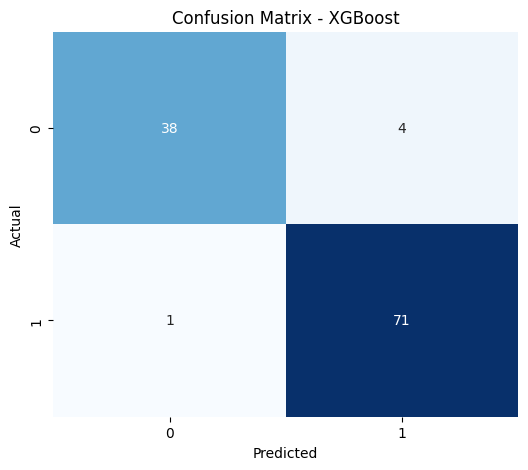

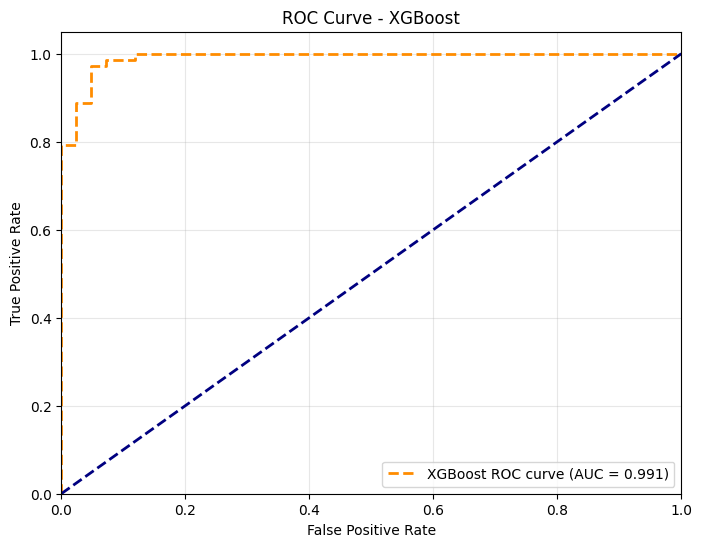

In [33]:
# --- Predict ---
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]  # probability for positive class

# --- Evaluate metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, linestyle='--', label=f'XGBoost ROC curve (AUC = {roc_auc_value:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()